# 03_tml_pca

We will stack PCA onto the 02 series notebooks to try and reduce the dimensions of our data. We think that not all features are important

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(280145, 138)
(120504, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


In [ ]:
# scaling data to make it easier for models to train
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
x_test = scaler.transform(x_test)

# Helper functions

In [ ]:
# constants
SEED = 42

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test=test, x_test=x_test, y_test=y_test):
  y_pred = model.predict(x_test) 

  print("Utility score: ", utility_score(test, y_pred))
  print("Accuracy: ", accuracy_score(y_test, y_pred))
  
  print("Confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()  

  print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# PCA
The idea behind PCA is to take the original features and compress them into a smaller set of features, while still keeping as much information as possible. As such, if we are compressing into k features, the 1st feature will retain as much % of the variance represented by the data and so on.

The end result is k features, but of note is that the new features have no logical meaning anymore since they are representations of a few features. This is fine as our features are anonymous to begin with - but an important point is that now we have to change our original data to fit the new transformed feature space.

In [ ]:
# import model
from sklearn.naive_bayes import GaussianNB

# settings to vary
var_smoothings = [1e-0, 1e-03, 1e-06, 1e-09, 1e-12]

In [ ]:
# import model
from sklearn import decomposition

# settings to vary
n_components = [70, 90, 110, 130]



Naive Bayes model: var_smoothing=1.0, n_components = 70
Utility score:  95.18269008025588
Accuracy:  0.5035434508398061
Confusion matrix


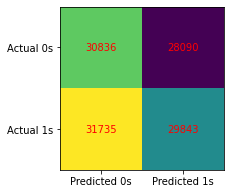

AUC_ROC


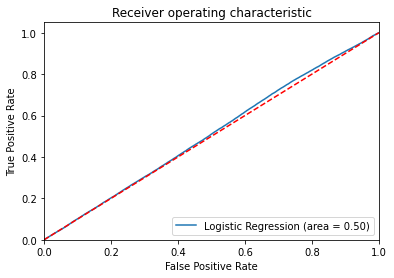



Naive Bayes model: var_smoothing=1.0, n_components = 90
Utility score:  104.14738559654282
Accuracy:  0.5039832702648874
Confusion matrix


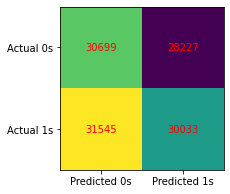

AUC_ROC


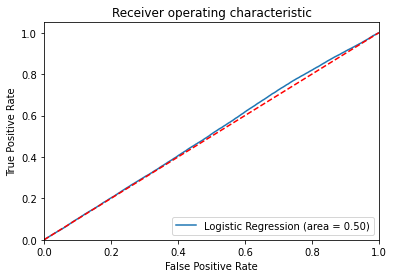



Naive Bayes model: var_smoothing=1.0, n_components = 110
Utility score:  105.5497417794574
Accuracy:  0.5039998672243245
Confusion matrix


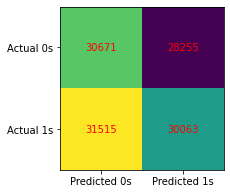

AUC_ROC


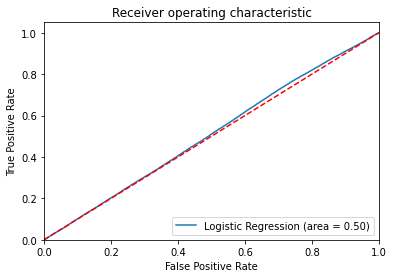



Naive Bayes model: var_smoothing=1.0, n_components = 130
Utility score:  103.54053909241267
Accuracy:  0.5039832702648874
Confusion matrix


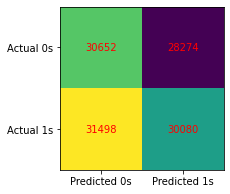

AUC_ROC


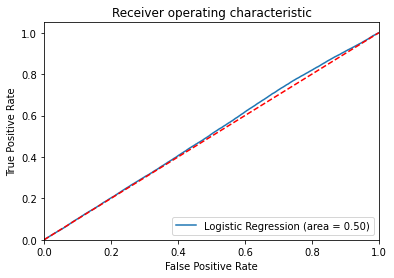



Naive Bayes model: var_smoothing=0.001, n_components = 70
Utility score:  619.9184008694074
Accuracy:  0.5028629755028878
Confusion matrix


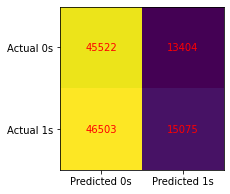

AUC_ROC


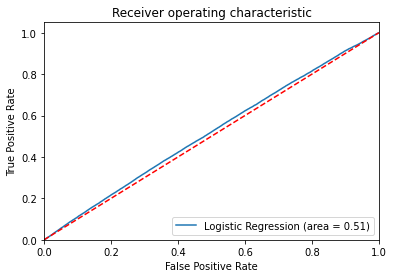



Naive Bayes model: var_smoothing=0.001, n_components = 90
Utility score:  585.6246530230165
Accuracy:  0.5048961030339242
Confusion matrix


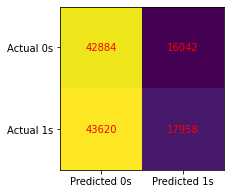

AUC_ROC


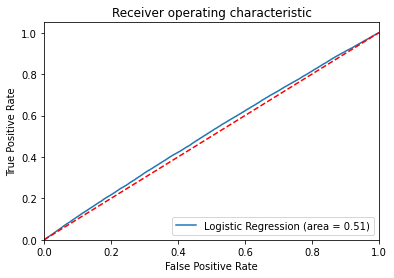



Naive Bayes model: var_smoothing=0.001, n_components = 110
Utility score:  513.5677450965849
Accuracy:  0.5063151430657904
Confusion matrix


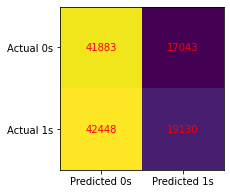

AUC_ROC


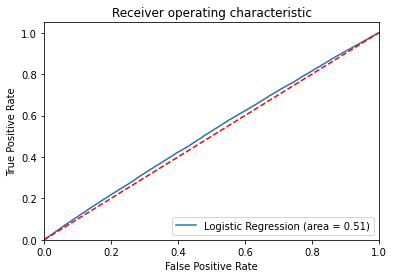



Naive Bayes model: var_smoothing=0.001, n_components = 130
Utility score:  481.39627883527066
Accuracy:  0.5072528712739826
Confusion matrix


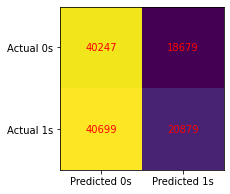

AUC_ROC


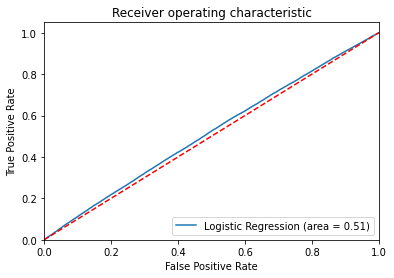



Naive Bayes model: var_smoothing=1e-06, n_components = 70
Utility score:  520.9255281201999
Accuracy:  0.5023567682400584
Confusion matrix


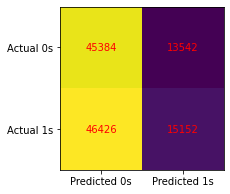

AUC_ROC


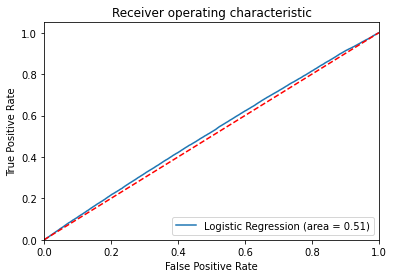



Naive Bayes model: var_smoothing=1e-06, n_components = 90
Utility score:  510.99165416278373
Accuracy:  0.50508696806745
Confusion matrix


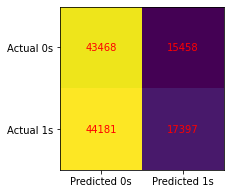

AUC_ROC


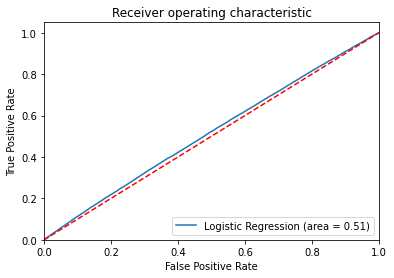



Naive Bayes model: var_smoothing=1e-06, n_components = 110
Utility score:  605.4236464086124
Accuracy:  0.503460466042621
Confusion matrix


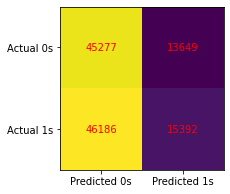

AUC_ROC


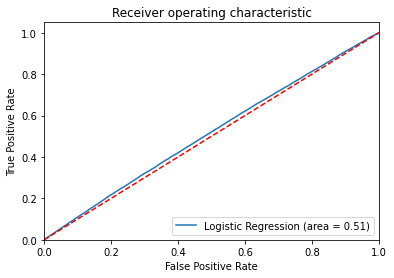



Naive Bayes model: var_smoothing=1e-06, n_components = 130
Utility score:  261.8866322903689
Accuracy:  0.505618070769435
Confusion matrix


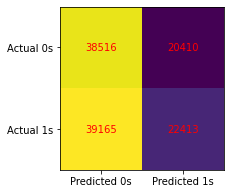

AUC_ROC


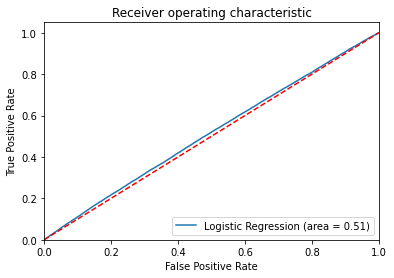



Naive Bayes model: var_smoothing=1e-09, n_components = 70
Utility score:  537.511205573248
Accuracy:  0.5022156940848437
Confusion matrix


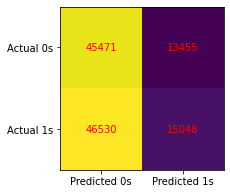

AUC_ROC


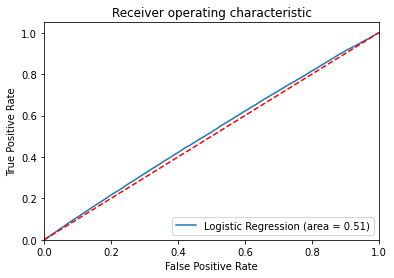



Naive Bayes model: var_smoothing=1e-09, n_components = 90
Utility score:  517.0864090751364
Accuracy:  0.5051533559051982
Confusion matrix


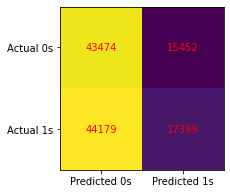

AUC_ROC


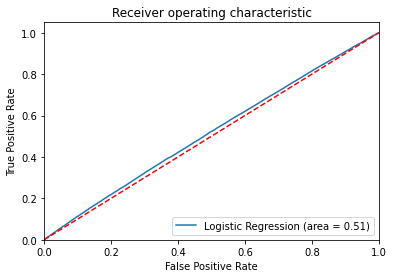



Naive Bayes model: var_smoothing=1e-09, n_components = 110
Utility score:  596.2169598328128
Accuracy:  0.5033359888468433
Confusion matrix


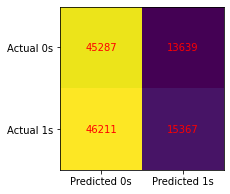

AUC_ROC


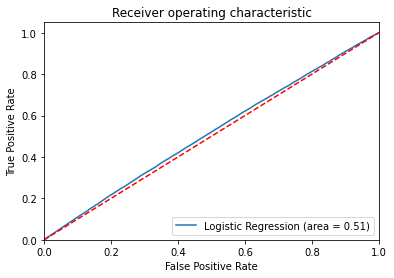



Naive Bayes model: var_smoothing=1e-09, n_components = 130
Utility score:  271.7328643262487
Accuracy:  0.5054355042156277
Confusion matrix


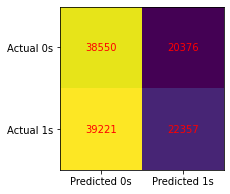

AUC_ROC


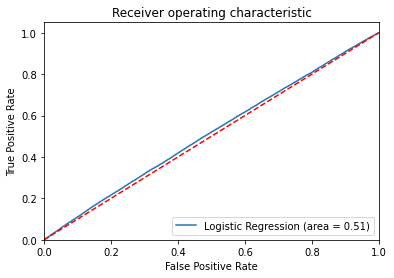



Naive Bayes model: var_smoothing=1e-12, n_components = 70
Utility score:  509.40229407843054
Accuracy:  0.5021659032065325
Confusion matrix


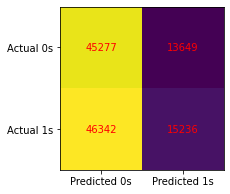

AUC_ROC


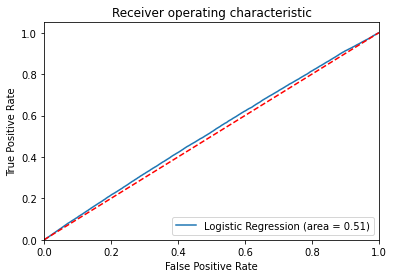



Naive Bayes model: var_smoothing=1e-12, n_components = 90
Utility score:  509.8566612825095
Accuracy:  0.505053774148576
Confusion matrix


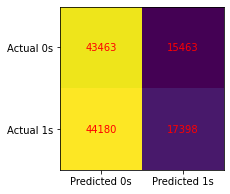

AUC_ROC


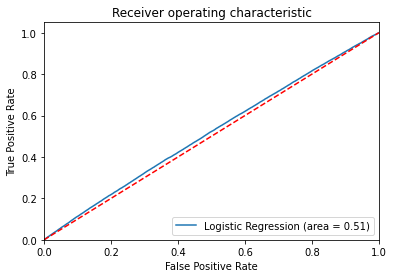



Naive Bayes model: var_smoothing=1e-12, n_components = 110
Utility score:  596.2169598328128
Accuracy:  0.5033359888468433
Confusion matrix


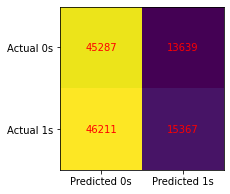

AUC_ROC


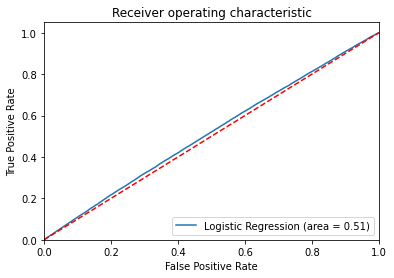



Naive Bayes model: var_smoothing=1e-12, n_components = 130
Utility score:  269.2530389348461
Accuracy:  0.5054272057359092
Confusion matrix


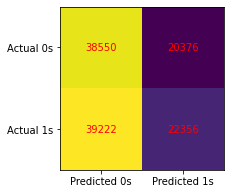

AUC_ROC


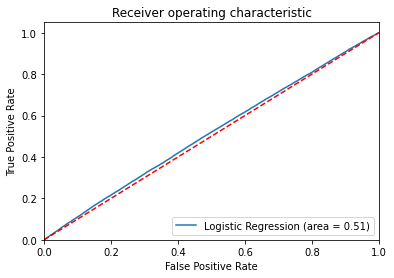

In [ ]:
# iterate over settings for the model
for var_smoothing in var_smoothings:
  for n_component in n_components:
    pca = decomposition.PCA(n_components=n_component)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    print(f"\n\nNaive Bayes model: var_smoothing={var_smoothing}, n_components = {n_component}")    
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(x_train_pca, y_train)
    model_scores(model, x_test=x_test_pca)

# Conclusion

Best model with params var_smoothing = 0.001, n_components = 70.

* Utility score : 619.9184009
* Accuracy : 0.5028629755

Except for var_smoothing = 0.001. General trend of highest utility score returned when n_components = 110, past which utility score decreases drastically.

Utility score achieved increased significantly with the introduction of PCA.
